In [1]:
import numpy as np
import pandas as pd

import os
import sys
sys.path.insert(0,'../../')
from MAP_estimator import MAP_estimator

from helpers import *
import statistics
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score,log_loss,accuracy_score, roc_curve, confusion_matrix

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load statistics of TCRs of training set
train = pd.read_csv('../data/'+'MAP_estimator/'+'train.csv')
train.head()

,sample_name,unique_TCRs,phenotype_associated_TCRs,phenotype_status
0,HIP09097,123638,2,0
1,HIP05561,153097,0,0
2,HIP13856,277546,12,1
3,HIP05398,218577,1,0
4,HIP13975,286379,16,1


In [3]:
train.mean()

unique_TCRs                  193665.992200
phenotype_associated_TCRs         6.926677
phenotype_status                  0.450858
dtype: float64

In [4]:
train[train.phenotype_status==0].mean()

unique_TCRs                  198229.846591
phenotype_associated_TCRs         1.877841
phenotype_status                  0.000000
dtype: float64

In [5]:
train[train.phenotype_status==1].mean()

unique_TCRs                  188107.249135
phenotype_associated_TCRs        13.076125
phenotype_status                  1.000000
dtype: float64

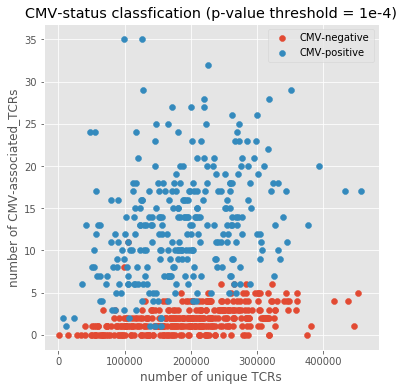

In [6]:
plt.figure(figsize=(6,6))
neg = train[train.phenotype_status==0]
pos = train[train.phenotype_status==1]
plt.scatter(neg.unique_TCRs,neg.phenotype_associated_TCRs,label='CMV-negative')
plt.scatter(pos.unique_TCRs,pos.phenotype_associated_TCRs,label='CMV-positive')
plt.xlabel('number of unique TCRs')
plt.ylabel('number of CMV-associated_TCRs')
plt.title('CMV-status classfication (p-value threshold = 1e-4)')
plt.legend()
plt.savefig('test.png')

In [ ]:
# lm = sns.lmplot(data=train,x='unique_TCRs',y='CMV_associated_TCRs',
#                            hue='phenotype_status',fit_reg=False,legend=True,legend_out=False)
# ax = plt.gca()
# ax.set_title('CMV-status classification')

In [6]:
# stat_c0 = statistics_TCRs_train[statistics_TCRs_train['CMV_status']==0]
# stat_c1 = statistics_TCRs_train[statistics_TCRs_train['CMV_status']==1]

# class_0 = go.Scatter(
#     x = stat_c0['unique_TCRs'],
#     y = stat_c0['CMV_associated_TCRs'],
#     mode = 'markers',
#     name = 'CMV-',
#     text = stat_c0['sample_name']
# )
    
# class_1 = go.Scatter(
#     x = stat_c1['unique_TCRs'],
#     y = stat_c1['CMV_associated_TCRs'],
#     mode = 'markers',
#     name = 'CMV+',
#     text = stat_c1['sample_name']
# )

# data = [class_0,class_1]
# py.iplot(data, filename='CMV-status_classification')

## Prediction

### Training set

In [7]:

prior_c0 = [32.06053757164488, 3380430.119349849]
prior_c1 = [3.982831455808779, 51767.51234300456]
MAP = MAP_estimator(prior_c0,prior_c1) # construct a MAP_estimator instance
MAP.fit(train,'unique_TCRs','phenotype_associated_TCRs','phenotype_status') # train the model using training set

y_pred = MAP.predict(train,'unique_TCRs','phenotype_associated_TCRs') # predict the label
y_proba = MAP.predict_proba_pos(train,'unique_TCRs','phenotype_associated_TCRs') # compute the positive-class posterior probability


print('Accuracy: %.3f'%accuracy_score(train['phenotype_status'],y_pred))
print('AUROC: %.3f'%roc_auc_score(train['phenotype_status'],y_proba))

Accuracy: 0.961
AUROC: 0.987


**AUROC**

**Cross Validation**

In [10]:
# def prior_init_moments1(train,ratio=True):
    
#     # subdataframes of different classes
#     train_c0 = train[train['phenotype_status']==0]
#     train_c1 = train[train['phenotype_status']==1]
    
#     # lists n, k, k/n of the negative class
#     n_c0 = train_c0['unique_TCRs'].tolist()
#     k_c0 = train_c0['phenotype_associated_TCRs'].tolist()
    
#     # lists n, k, k/n of the positive class
#     n_c1 = train_c1['unique_TCRs'].tolist()
#     k_c1 = train_c1['phenotype_associated_TCRs'].tolist()
    
    
#     ratio_c0 = np.array(k_c0)/np.array(n_c0)
#     ratio_c1 = np.array(k_c1)/np.array(n_c1)
    
#     # a and b are computed for separate class by the formula in BDA3 pp.583
#     ab_c0 = (np.mean(ratio_c0)*(1-np.mean(ratio_c0))/np.var(ratio_c0))-1
#     a_c0 = ab_c0*np.mean(ratio_c0)
#     b_c0 = ab_c0*(1-np.mean(ratio_c0))
    
#     ab_c1 = (np.mean(ratio_c1)*(1-np.mean(ratio_c1))/np.var(ratio_c1))-1
#     a_c1 = ab_c1*np.mean(ratio_c1)
#     b_c1 = ab_c1*(1-np.mean(ratio_c1))
    
#     return [[a_c0,b_c0],[a_c1,b_c1]]

# def prior_init_moments2(train):
    
#     train_c0 = train[train['phenotype_status']==0]
#     train_c1 = train[train['phenotype_status']==1]
    
#     n_c0 = train_c0['unique_TCRs'].tolist()
#     k_c0 = train_c0['phenotype_associated_TCRs'].tolist()
#     N_c0 = np.mean(n_c0)
    
#     n_c1 = train_c1['unique_TCRs'].tolist()
#     k_c1 = train_c1['phenotype_associated_TCRs'].tolist()
#     N_c1 = np.mean(n_c1)
    
#     mu1_c0 = np.mean(np.array(k_c0))
#     mu2_c0 = np.mean(np.array(k_c0)**2)
    
#     mu1_c1 = np.mean(np.array(k_c1))
#     mu2_c1 = np.mean(np.array(k_c1)**2)
    
#     a_c0 = (N_c0*mu1_c0-mu2_c0)/(N_c0*((mu2_c0/mu1_c0)-mu1_c0-1)+mu1_c0)
#     b_c0 = (N_c0-mu1_c0)*(N_c0-(mu2_c0/mu1_c0))/(N_c0*((mu2_c0/mu1_c0)-mu1_c0-1)+mu1_c0)
    
#     a_c1 = (N_c1*mu1_c1-mu2_c1)/(N_c1*((mu2_c1/mu1_c1)-mu1_c1-1)+mu1_c1)
#     b_c1 = (N_c1-mu1_c1)*(N_c1-(mu2_c1/mu1_c1))/(N_c1*((mu2_c1/mu1_c1)-mu1_c1-1)+mu1_c1)
    
#     return [[a_c0,b_c0],[a_c1,b_c1]]

In [6]:
train_c0 = train[train['phenotype_status']==0]
train_c1 = train[train['phenotype_status']==1]

# lists n, k, k/n of the negative class
n_c0 = train_c0['unique_TCRs'].values
k_c0 = train_c0['phenotype_associated_TCRs'].values

# lists n, k, k/n of the positive class
n_c1 = train_c1['unique_TCRs'].values
k_c1 = train_c1['phenotype_associated_TCRs'].values
    

In [7]:
mean = statistics.mean(k_c0)
var = statistics.variance(k_c0)*len(k_c0)

theta = np.sum(k_c0)/np.sum(n_c0)
n = np.sum(n_c0)
n2 = np.sum(n_c0**2)

In [8]:
temp = (n2/n)-1
temp2 = n*theta*(1-theta)
temp3 = var-n*theta*(1-theta)

In [9]:
n_c0[0]*theta*(1-theta)

1.1712176492577642

In [10]:
theta*temp*(temp2/temp3)

33.790283280382305

In [15]:
mean = statistics.mean(k_c1)
var = statistics.variance(k_c1)*len(k_c1)

theta = np.sum(k_c1)/np.sum(n_c1)
n = np.sum(n_c1)
n2 = np.sum(n_c1**2)

mean = statistics.mean(k_c0)
var = statistics.variance(k_c0)*len(k_c0)

theta = np.sum(k_c0)/np.sum(n_c0)
n = np.sum(n_c0)
n2 = np.sum(n_c0**2)

temp = (n2/n)-1
temp2 = n*theta*(1-theta)
temp3 = var-n*theta*(1-theta)

alpha = theta*temp*(temp2/temp3)
beta = (1-theta)*alpha/theta

In [16]:
print(alpha,beta)

33.790283280382305 3566957.768216883


In [ ]:
def prior_MOM(train):
    # subdataframes of different classes
    train_c0 = train[train['phenotype_status']==0]
    train_c1 = train[train['phenotype_status']==1]
    
    # lists n, k, k/n of the negative class
    n_c0 = train_c0['unique_TCRs'].tolist()
    k_c0 = train_c0['phenotype_associated_TCRs'].tolist()
    
    # lists n, k, k/n of the positive class
    n_c1 = train_c1['unique_TCRs'].tolist()
    k_c1 = train_c1['phenotype_associated_TCRs'].tolist()
    
    
    

In [29]:
threshold = 1e-4
y_true = []
y_proba = [] 
loo = LeaveOneOut()

def MAP_predict(train,test,prior_c0,prior_c1):
        '''
        Predicting testing data
        '''
        MAP = MAP_estimator(prior_c0,prior_c1) # construct a MAP_estimator instance
        MAP.fit(train,'unique_TCRs','phenotype_associated_TCRs','phenotype_status') # train the model using training set
        print('optimized priors:', 'class 0:', list(np.around(MAP.priors()[0],3)),
            ', class 1:', list(np.around(MAP.priors()[1],3))) # print the optimized priors

        y_pred = MAP.predict(test,'unique_TCRs','phenotype_associated_TCRs')[0] # predict the label
        y_proba = MAP.predict_proba_pos(test,'unique_TCRs','phenotype_associated_TCRs')[0] # compute the positive-class posterior probability

        return y_pred, y_proba


for train_index,test_index in loo.split(train):
    train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]
    test_sample = test_cv['sample_name'].values[0]
    MAP_data = pd.read_pickle('../data/LOO_MAP_data/'+test_sample+'.pkl')

    MAP_data['phenotype_associated_TCRs']= MAP_data[threshold]
    train_MAP = MAP_data[MAP_data.sample_name.isin(train_cv['sample_name'])]
    test_MAP = MAP_data[MAP_data.sample_name.isin(test_cv['sample_name'])]

#     priors_init = prior_init_moments1(train_MAP)
#     print('priors initialization:','class 0:', list(np.around(np.array(priors_init[0]),3)),
#         ', class 1:', list(np.around(np.array(priors_init[1]),3)))
#     prior_c0 = priors_init[0]
#     prior_c1 = priors_init[1]
    test_pred, test_proba = MAP_predict(train_MAP,test_MAP,prior_c0,prior_c1)

    print('test sample:',test_sample, ', unique_TCRs:',test_MAP['unique_TCRs'].tolist()[0],', associated_TCRs:',test_MAP['phenotype_associated_TCRs'].tolist()[0])           
    print('y_true:',test_MAP['phenotype_status'].tolist()[0],', y_pred:',test_pred,
        ', y_proba_pos: %.3f'%test_proba)
    print()
    y_true.append(test_MAP['phenotype_status'].tolist()[0])
    y_proba.append(test_proba)
print('loocv auroc: %.3f' % roc_auc_score(y_true,y_proba))
print('loocv log_loss: %.3f' % log_loss(y_true,y_proba))

# fpr_cv,tpr_cv,thresholds_cv = roc_curve(cv_y,cv_post_pos,pos_label=1)
# print('roc_auc_score:',roc_auc_score(cv_y,cv_post_pos))

optimized priors: class 0: [919.601, 2799996.766] , class 1: [88.806, 49998.134]
test sample: HIP09097 , unique_TCRs: 123638 , associated_TCRs: 101
y_true: 0 , y_pred: 1 , y_proba_pos: 1.000

optimized priors: class 0: [927.654, 2799996.769] , class 1: [89.189, 49998.125]
test sample: HIP05561 , unique_TCRs: 153097 , associated_TCRs: 132
y_true: 0 , y_pred: 1 , y_proba_pos: 1.000

optimized priors: class 0: [865.25, 2799996.679] , class 1: [85.693, 49998.235]
test sample: HIP13856 , unique_TCRs: 277546 , associated_TCRs: 220
y_true: 1 , y_pred: 1 , y_proba_pos: 1.000

optimized priors: class 0: [934.262, 2799996.77] , class 1: [89.366, 49998.106]
test sample: HIP05398 , unique_TCRs: 218577 , associated_TCRs: 142
y_true: 0 , y_pred: 0 , y_proba_pos: 0.080

optimized priors: class 0: [859.28, 2799996.659] , class 1: [85.342, 49998.242]
test sample: HIP13975 , unique_TCRs: 286379 , associated_TCRs: 290
y_true: 1 , y_pred: 1 , y_proba_pos: 1.000

optimized priors: class 0: [866.772, 279999

### Testing set

In [8]:
test = pd.read_csv('../data/'+'MAP_estimator/'+'test.csv')

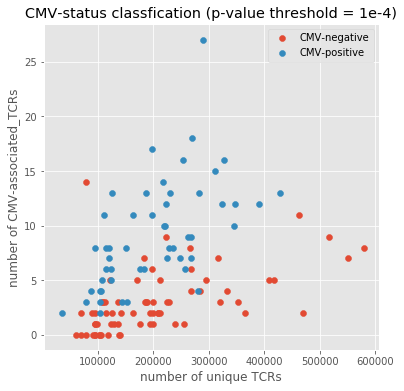

In [9]:
plt.figure(figsize=(6,6))
neg = test[test.phenotype_status==0]
pos = test[test.phenotype_status==1]
plt.scatter(neg.unique_TCRs,neg.phenotype_associated_TCRs,label='CMV-negative')
plt.scatter(pos.unique_TCRs,pos.phenotype_associated_TCRs,label='CMV-positive')
plt.xlabel('number of unique TCRs')
plt.ylabel('number of CMV-associated_TCRs')
plt.title('CMV-status classfication (p-value threshold = 1e-4)')
plt.legend()
plt.savefig('test_data.png')

In [ ]:
# lm = sns.lmplot(data=statistics_TCRs_test,x='unique_TCRs',y='phenotype_associated_TCRs',
#                            hue='phenotype_status',fit_reg=False,legend=True,legend_out=False)
# ax = plt.gca()
# ax.set_title('CMV_asso TCRs enriched in positive samples')

**accuracy score**

In [10]:
y_pred = MAP.predict(test,'unique_TCRs','phenotype_associated_TCRs') # predict the label
y_proba = MAP.predict_proba_pos(test,'unique_TCRs','phenotype_associated_TCRs') # compute the positive-class posterior probability


print('Accuracy: %.3f'%accuracy_score(test['phenotype_status'],y_pred))
print('AUROC: %.3f'%roc_auc_score(test['phenotype_status'],y_proba))
print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(test['phenotype_status'],y_pred),columns=['Predicted_negative','Predicted_positive'],
                        index=['Actual_negative','Actual_positive']))

Accuracy: 0.892
AUROC: 0.939
Confusion matrix:
                 Predicted_negative  Predicted_positive
Actual_negative                  61                   8
Actual_positive                   5                  46


**AUROC**

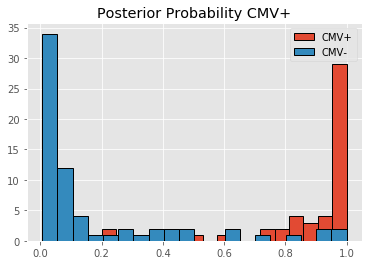

In [11]:
# posterior probability on CMV+
test_pred_df = pd.DataFrame({'phenotype_status':test['phenotype_status'],'posterior_proba_CMV+':y_proba})
CMV_pos_post = test_pred_df[test_pred_df['phenotype_status']==1]['posterior_proba_CMV+']
CMV_neg_post = test_pred_df[test_pred_df['phenotype_status']==0]['posterior_proba_CMV+']

# histograms of the posteriror probabilities
plt.hist(CMV_pos_post,edgecolor='black', bins=20,linewidth=1,label='CMV+')
plt.hist(CMV_neg_post,edgecolor='black', bins=20,linewidth=1,label='CMV-')
plt.title('Posterior Probability CMV+')
plt.legend(loc='best')